In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy import spatial

from utils import remove_hidden_points, edblquad
from plotting import set_axes_equal, set_defense_context

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
def sphere(r, samples=1000):
    # https://stackoverflow.com/a/44164075/15005103
    i = np.arange(0, samples, dtype=float) + 0.5
    phi = np.arccos(1 - 2 * i / samples)
    theta = np.pi * (1 + np.sqrt(5)) * i
    x = r * np.cos(theta) * np.sin(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(phi)
    return np.c_[x, y, z]

In [4]:
# generate coordinates of a sphere

r = 5  # cm
samples = 10000
xyz = sphere(r, samples)

In [5]:
# create 2 synthetic absorbed power density patterns

mask = np.where(xyz[:, 0] > 0)[0]  # the wave propagates in the x-direction
y = xyz[mask, 1]
z = xyz[mask, 2]

center_1 = [0, 0]
radius_1 = 0.5
region_1 = np.sqrt(((y - center_1[0]) / 1.5) ** 2 + (z - center_1[1]) ** 2)
apd_1 = 15.1 * np.exp(-(region_1 / radius_1) ** 2)

center_2 = [2.5, -1]
radius_2 = 1.5
region_2 = np.sqrt((y - center_2[0]) ** 2 + (z - center_2[1]) ** 2)
apd_2 = 10 * np.exp(-(region_2 / radius_2) ** 2)

apd = np.zeros((xyz.shape[0], ))
apd[mask] = apd_1 + apd_2

# Fixed POV

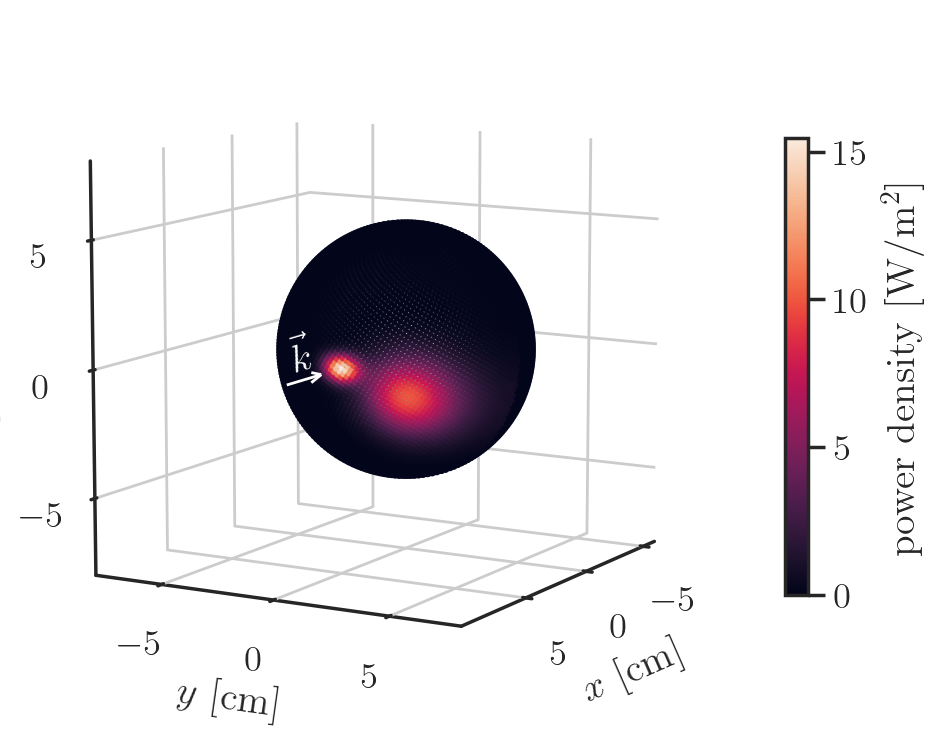

In [6]:
with set_defense_context():
    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes(projection ='3d')
    s = ax.scatter(*xyz.T, s=1, c=apd)
    fig.colorbar(s, ax=ax, pad=0.075, shrink=0.5,
                 label='power density [W/m$^2$]')
    ax.quiver(9, 0, 0, -2.5, 0, 0, lw=1, color='w')
    ax.text(9, 0, 0.5, s='$\\vec k$', color='w', zdir='x')
    ax.set(xlabel='$x$ [cm]', ylabel='$y$ [cm]', zlabel='$z$ [cm]')
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.set_box_aspect([1, 1, 1])
    ax = set_axes_equal(ax)
    ax.view_init(10, 30)
    fig.tight_layout()
    plt.show()

In [7]:
# remove points not visible from the pov of wave incidence onto the model

center = np.mean(xyz, axis=0)
diameter = np.linalg.norm(xyz.max(axis=0) - xyz.min(axis=0))
pov = center.copy()
pov[0] += diameter
idx_visible = remove_hidden_points(xyz, pov, np.pi)
xyz_visible = xyz[idx_visible]
apd_visible = apd[idx_visible]

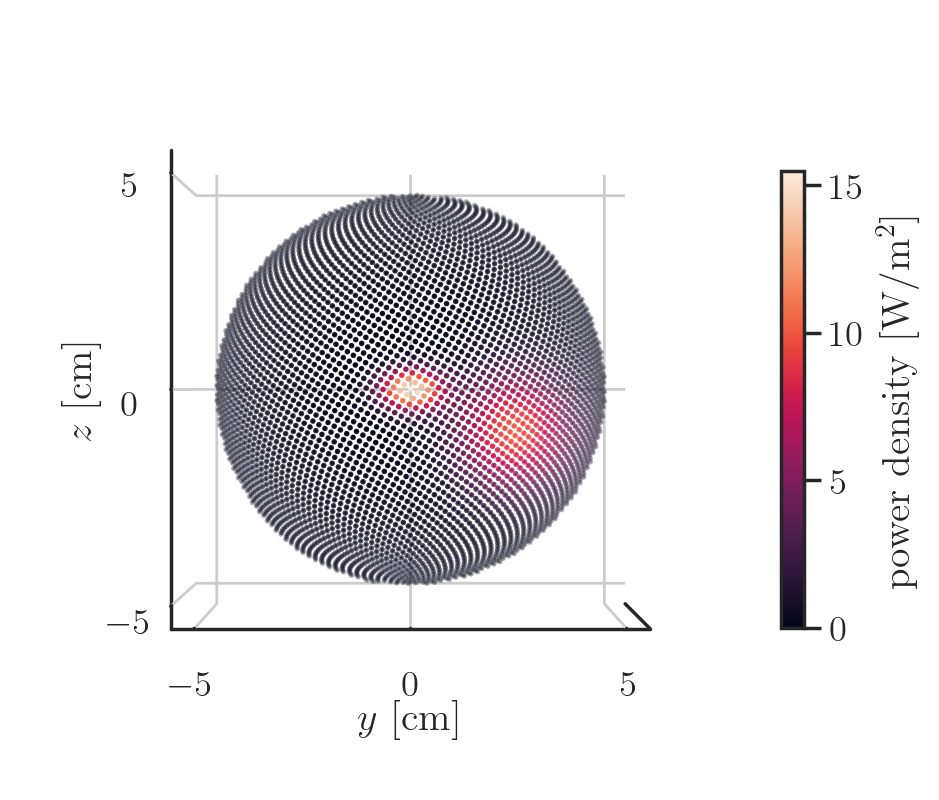

In [8]:
with set_defense_context():
    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes(projection ='3d')
    s = ax.scatter(*xyz_visible.T, c=apd_visible, s=1)
    fig.colorbar(s, ax=ax, pad=0, shrink=0.5,
                 label='power density [W/m$^2$]')
    ax.set(xlabel='', ylabel='$y$ [cm]', zlabel='$z$ [cm]',
           xticks=[], xticklabels=[],
           yticks=[-r, 0, r],
           zticks=[-r, 0, r])
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.set_box_aspect([1, 1, 1])
    ax = set_axes_equal(ax)
    ax.view_init(0, 0)
    fig.tight_layout()
    plt.show()

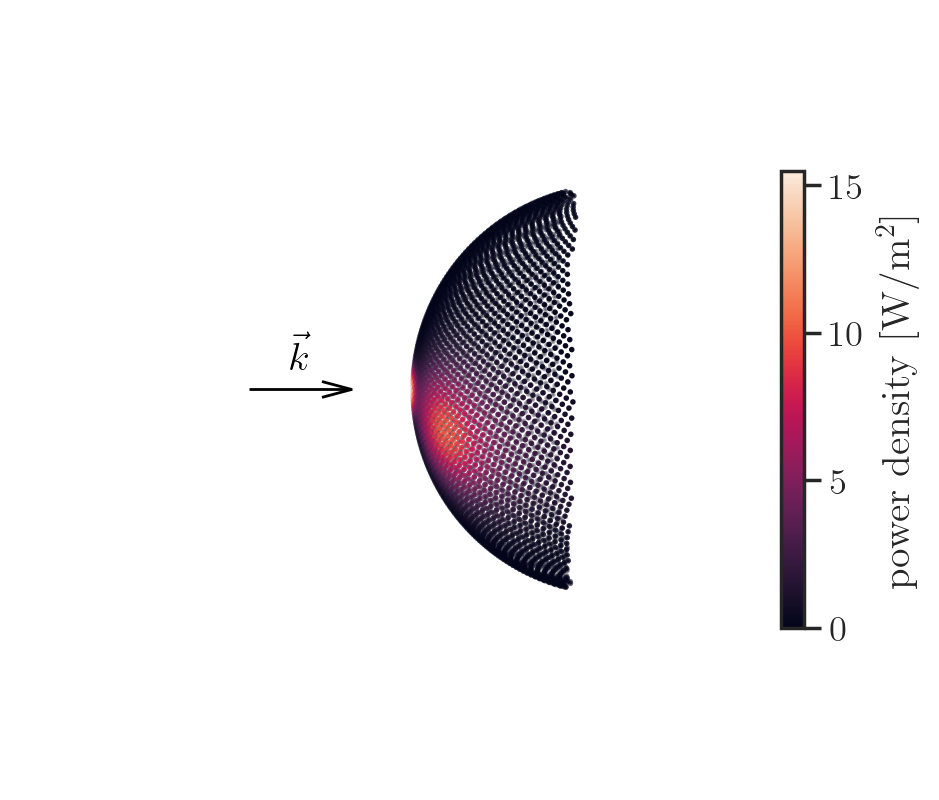

In [9]:
with set_defense_context():
    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes(projection ='3d')
    s = ax.scatter(*xyz_visible.T, c=apd_visible, s=1)
    fig.colorbar(s, ax=ax, pad=0, shrink=0.5,
                 label='power density [W/m$^2$]')
    ax.quiver(9, 0, 0, -2.5, 0, 0, lw=1, color='k')
    ax.text(8, 0, 0.5, s='$\\vec k$', color='k', zdir='x')
    ax.set_box_aspect([1, 1, 1])
    ax = set_axes_equal(ax)
    ax.set_axis_off()
    ax.view_init(0, 90)
    fig.tight_layout()
    plt.show()

In [10]:
# algorithm for a fixed pov

# control area
area = 4  # cm2
a = np.sqrt(area)

# placeholder for computations
res_1 = {'p': [], 'nbhd': [], 'area_conf': [], 'apd': [], 'sapd': []}

for p in xyz_visible:
    # bounding box around each point perpendicular to the k vector (yz-plane)
    _bbox = [p[1]-a/2, p[1]+a/2, p[2]-a/2, p[2]+a/2]
    _idx_bbox = np.where((xyz_visible[:, 1] >= _bbox[0])
                         & (xyz_visible[:, 1] <= _bbox[1])
                         & (xyz_visible[:, 2] >= _bbox[2])
                         & (xyz_visible[:, 2] <= _bbox[3]))[0]
    _nbhd = xyz_visible[_idx_bbox]
    _apd = apd_visible[_idx_bbox]
    # create a convex hull for the local point cloud within the bounding box
    _hull = spatial.ConvexHull(_nbhd[:, 1:])
    # compute the area of a convex hull by considering yz-plane
    _hull_area = _hull.volume  # for 2-D `volume` results with an area
    # relative % difference between control area and the area of a convex hull
    rpd = np.abs(_hull_area - area) / area
    if rpd > 0.1:
        continue  # skip iteration if the difference is too large
    else:
        # fit a local surface
        fi = interpolate.SmoothBivariateSpline(*_nbhd[:, 1:].T,  # yz
                                               _nbhd[:, 0],      # x
                                               kx=5, ky=5)
        # compute the normals on a local surface
        _n = np.c_[fi(*_nbhd[:, 1:].T, dx=1, grid=False),   # dy
                   fi(*_nbhd[:, 1:].T, dy=1, grid=False),   # dz
                   np.ones((_nbhd.shape[0]))]
        _n_mag = np.linalg.norm(_n, axis=1)  # magnitude of the normals
        _area_conf = edblquad(_nbhd[:, 1:], _n_mag)  # conformal area
        _sapd = edblquad(_nbhd[:, 1:], _apd) / _area_conf  # surface integral
        # capture the results
        res_1['p'].append(p)
        res_1['nbhd'].append(_nbhd)
        res_1['area_conf'].append(_area_conf)
        res_1['apd'].append(_apd)
        res_1['sapd'].append(_sapd)
res_1_df = pd.DataFrame(res_1)

In [11]:
# extract the spatial maximum absorbed power density

ctrl_p, ctrl_nbhd, ctrl_area_conf, ctrl_apd, ctrl_sapd = res_1_df[
    res_1_df['sapd'] == res_1_df['sapd'].max()
].to_numpy()[0].T

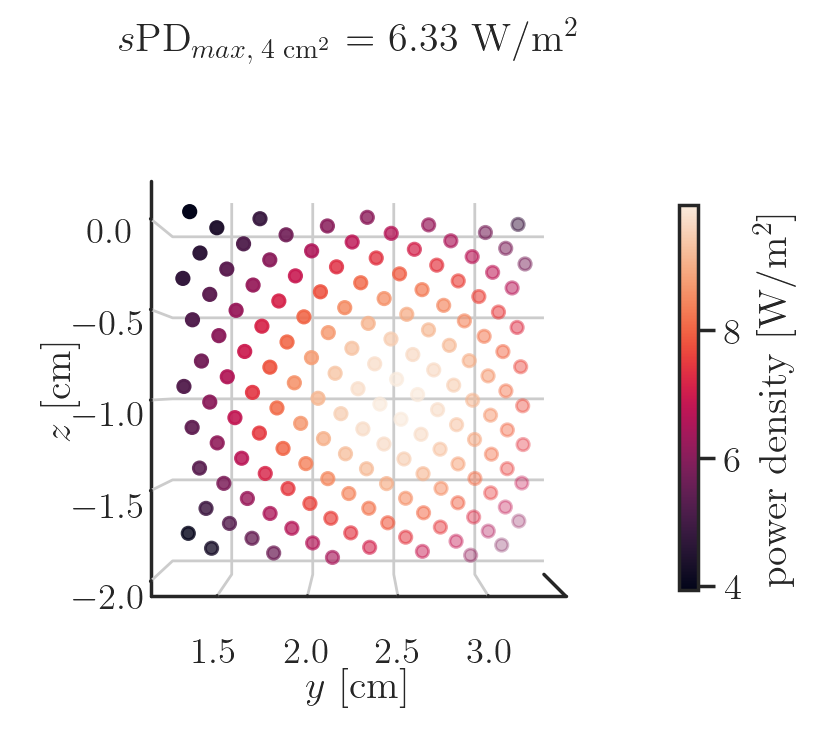

In [12]:
with set_defense_context():
    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes(projection ='3d')
    s = ax.scatter(*ctrl_nbhd.T, c=ctrl_apd)
    fig.colorbar(s, ax=ax, pad=0, shrink=0.5,
                 label='power density [W/m$^2$]')
    ax.set(xlabel='', ylabel='$y$ [cm]', zlabel='$z$ [cm]',
           title=(r'$s\text{PD}_{max, \; 4 \; \text{cm}^2}$ = '
                  f'{ctrl_sapd:.2f} W/m$^2$'),
           xticks=[], xticklabels=[])
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.set_box_aspect([1, 1, 1])
    ax = set_axes_equal(ax)
    ax.view_init(0, 0)
    plt.show()

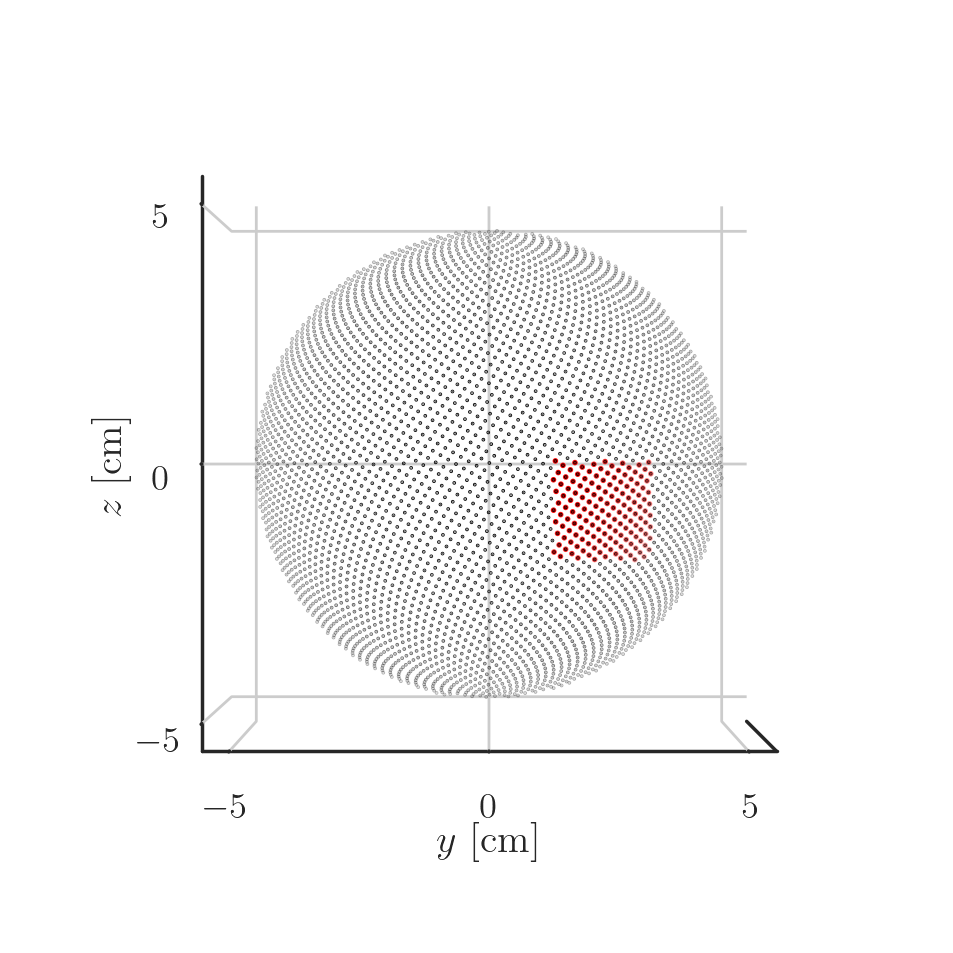

In [13]:
with set_defense_context():
    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes(projection ='3d')
    ax.scatter(*xyz_visible.T, c='k', s=0.1)
    ax.scatter(*ctrl_nbhd.T, c='r', s=1)
    ax.set(xlabel='', ylabel='$y$ [cm]', zlabel='$z$ [cm]',
           xticks=[], xticklabels=[],
           yticks=[-r, 0, r],
           zticks=[-r, 0, r])
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.set_box_aspect([1, 1, 1])
    ax = set_axes_equal(ax)
    ax.view_init(0, 0)
    fig.tight_layout()
    plt.show()

# POV perpendicular to the normal direction

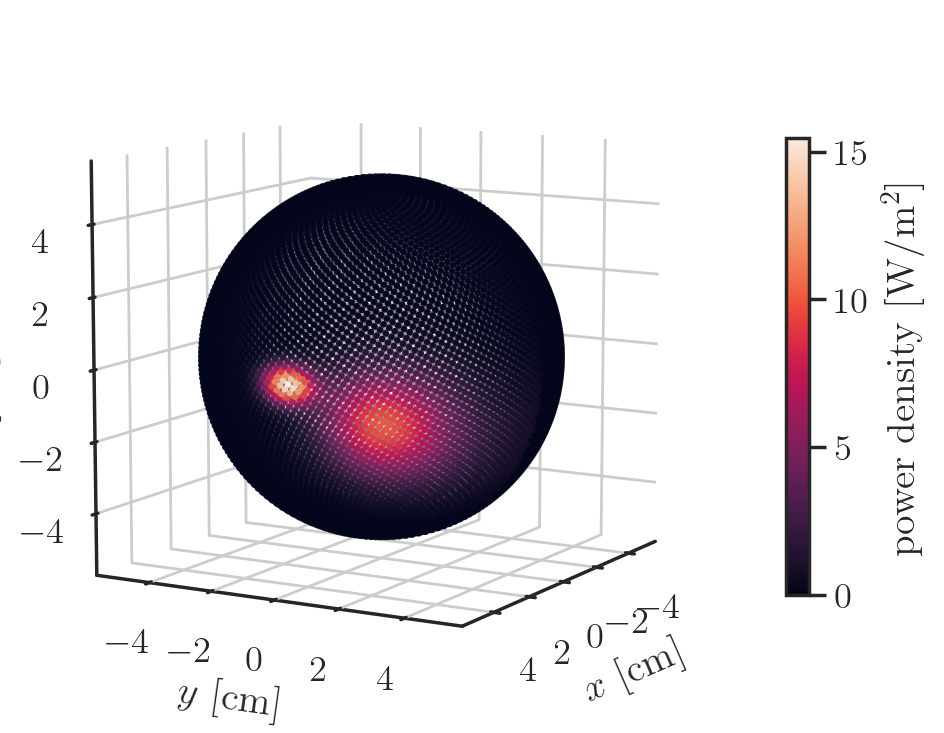

In [14]:
with set_defense_context():
    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes(projection ='3d')
    s = ax.scatter(*xyz.T, s=2, c=apd)
    fig.colorbar(s, ax=ax, pad=0.075, shrink=0.5,
                 label='power density [W/m$^2$]')
    ax.set(xlabel='$x$ [cm]', ylabel='$y$ [cm]', zlabel='$z$ [cm]')
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.set_box_aspect([1, 1, 1])
    ax = set_axes_equal(ax)
    ax.view_init(10, 30)
    fig.tight_layout()
    plt.show()

In [15]:
# algorithm for the POV perpendicular to the normal direction

# control area
area = 4  # cm2
a = np.sqrt(area)
rc = a / np.sqrt(2)  # radius of a circumscribed circle of a square

# k-D tree of the point cloud
tree = spatial.KDTree(xyz)

# placeholder for computations
res_2 = {'p': [], 'nbhd': [], 'area_conf': [], 'apd': [], 'sapd': []}
for p in xyz:
    # find all points within radius rc, i.e., from rc/(1+eps) to rc*(1+eps)
    _nbhd_idx = tree.query_ball_point([p], rc, eps=0.01, workers=-1)[0]
    _nbhd = xyz[_nbhd_idx]
    # map a local point cloud into orthogonal basis
    X = _nbhd.copy()
    X_mean = X.mean(axis=0)
    X_norm = X - X_mean
    p_norm = p - X_mean
    C = X_norm.T @ X_norm  # covariance matrix
    U, _, _ = np.linalg.svd(C)
    X_trans = X_norm @ U
    p_trans = p_norm @ U
    # unpack into parametrized variables
    u, v = X_trans[:, :-1].T
    pu, pv = p_trans[:-1]
    # bounding box that corresponds to the control square area
    _bbox = [pu-a/2, pu+a/2,
             pv-a/2, pv+a/2]
    _idx_bbox = np.where((u >= _bbox[0]) & (u <= _bbox[1])
                         & (v >= _bbox[2]) & (v <= _bbox[3]))[0]
    _nbhd_bounded = _nbhd[_idx_bbox]
    # double integral on a parametrized surface
    _apd = apd[_nbhd_idx][_idx_bbox]
    _sapd = edblquad(X_trans[_idx_bbox, :-1], _apd) / area
    # capture the results
    res_2['p'].append(p)
    res_2['nbhd'].append(_nbhd_bounded)
    res_2['area_conf'].append(area)  # this is always the same by default
    res_2['apd'].append(_apd)
    res_2['sapd'].append(_sapd)
res_2_df = pd.DataFrame(res_2)

In [16]:
# spatial maximum

ctrl_p, ctrl_nbhd, ctrl_area_conf, ctrl_apd, ctrl_sapd = res_2_df[
    res_2_df['sapd'] == res_2_df['sapd'].max()
].to_numpy()[0].T

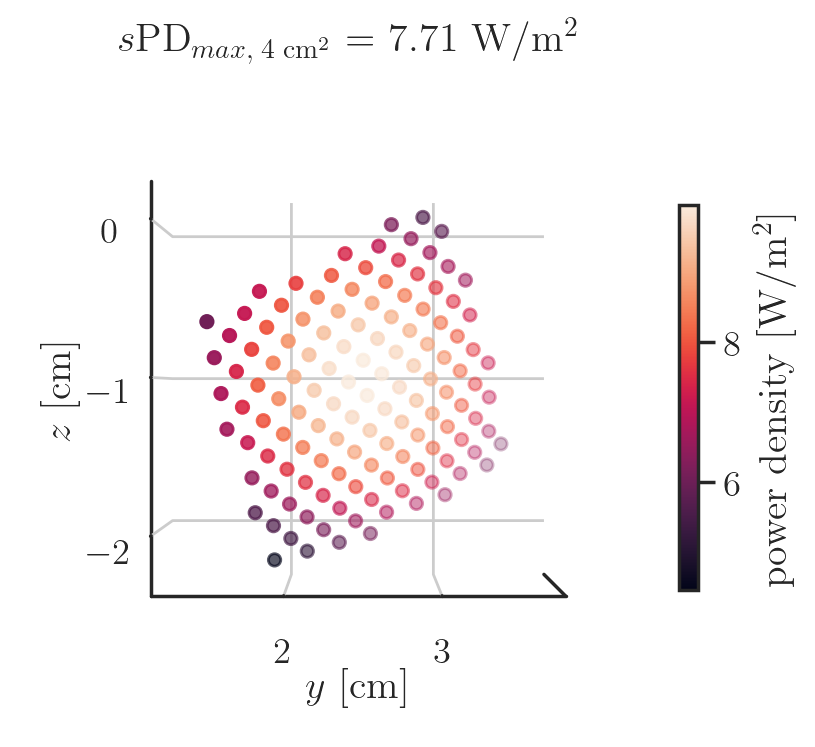

In [17]:
with set_defense_context():
    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes(projection ='3d')
    s = ax.scatter(*ctrl_nbhd.T, c=ctrl_apd)
    fig.colorbar(s, ax=ax, pad=0, shrink=0.5,
                 label='power density [W/m$^2$]')
    ax.set(xlabel='', ylabel='$y$ [cm]', zlabel='$z$ [cm]',
           title=(r'$s\text{PD}_{max, \; 4 \; \text{cm}^2}$ = '
                  f'{ctrl_sapd:.2f} W/m$^2$'),
           xticks=[], xticklabels=[])
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.set_box_aspect([1, 1, 1])
    ax = set_axes_equal(ax)
    ax.view_init(0, 0)
    plt.show()

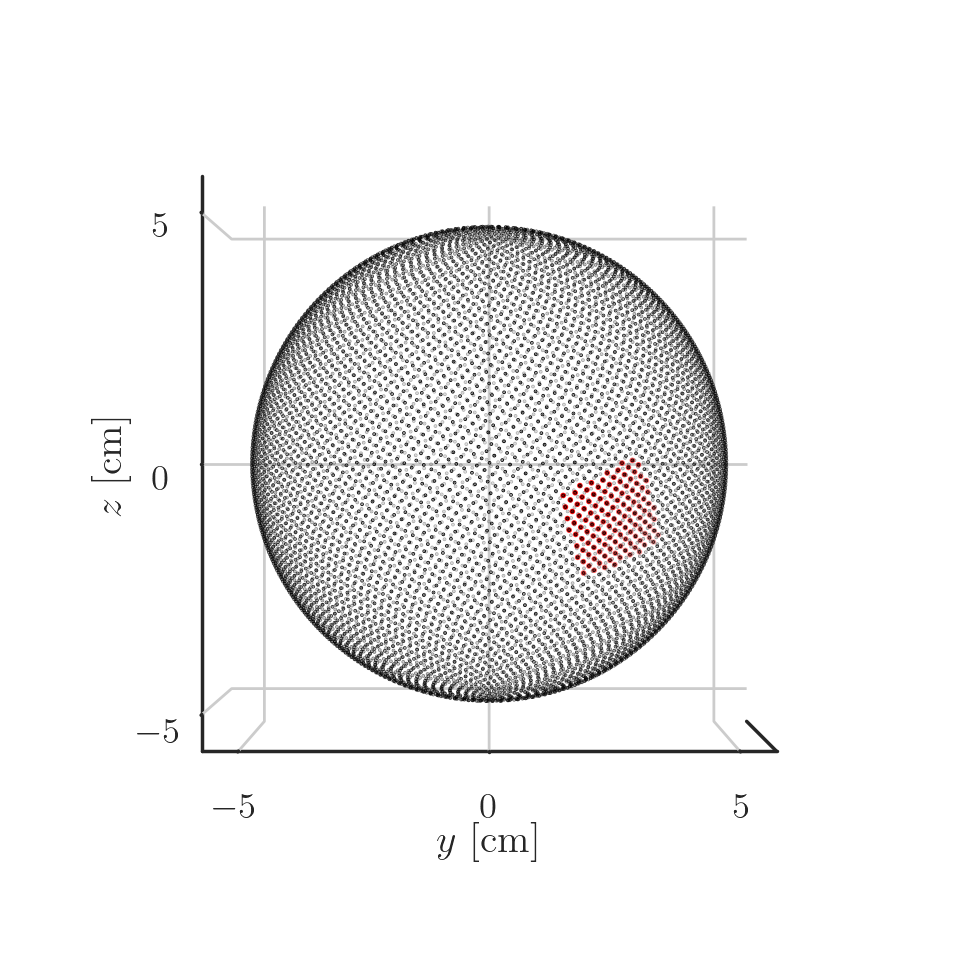

In [18]:
with set_defense_context():
    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes(projection ='3d')
    ax.scatter(*xyz.T, c='k', s=0.1, depthshade=True)
    ax.scatter(*ctrl_nbhd.T, c='r', s=1)
    ax.set(xlabel='', ylabel='$y$ [cm]', zlabel='$z$ [cm]',
           xticks=[], xticklabels=[],
           yticks=[-r, 0, r],
           zticks=[-r, 0, r])
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.set_box_aspect([1, 1, 1])
    ax = set_axes_equal(ax)
    ax.view_init(0, 0)
    fig.tight_layout()
    plt.show()

# Anatomical model

In [3]:
%matplotlib widget

In [4]:
# load ear coordinates

xyz = pd.read_csv(os.path.join('data', 'ear.xyz')).values * 100  # in cm

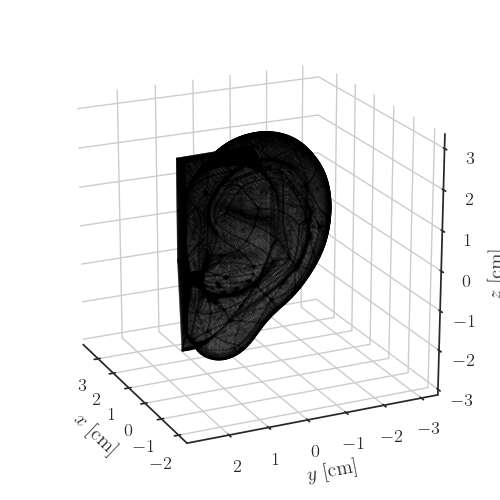

In [6]:
with set_defense_context():
    fig = plt.figure('ear model', figsize=(5, 5))
    ax = plt.axes(projection ='3d')
    s = ax.scatter(*xyz.T, c='k', s=0.1)
    ax.set(xlabel='$x$ [cm]', ylabel='$y$ [cm]', zlabel='$z$ [cm]')
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.set_box_aspect([1, 1, 1])
    ax = set_axes_equal(ax)
    ax.view_init(20, 155)
    fig.tight_layout()
    plt.show()

In [52]:
p = [3.21511545e-01, -2.64411695e-05, -1.64346896e+00]

area = 1  # cm2
a = np.sqrt(area)
rc = a / np.sqrt(2)  # radius of a circumscribed circle of a square

tree = spatial.KDTree(xyz)
idx = tree.query_ball_point([p], rc, eps=0.01, workers=-1)[0]
nbhd = xyz[idx]

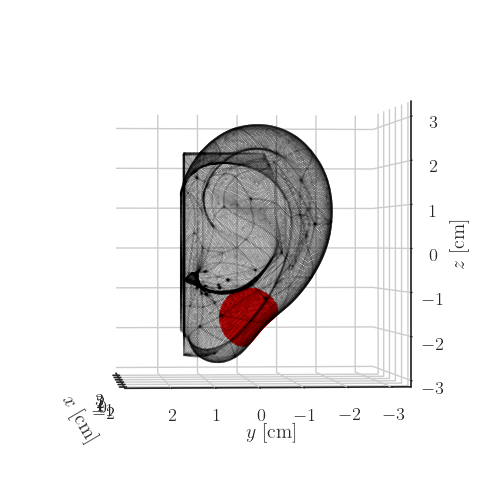

In [51]:
with set_defense_context():
    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes(projection ='3d')
    s = ax.scatter(*xyz.T, c='k', s=0.01)
    ax.scatter(*nbhd.T, c='r', s=0.3)
    ax.set(xlabel='$x$ [cm]', ylabel='$y$ [cm]', zlabel='$z$ [cm]')
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.set_box_aspect([1, 1, 1])
    ax = set_axes_equal(ax)
    ax.view_init(0, 175)
    fig.tight_layout()
    plt.show()

In [53]:
X = nbhd.copy()
X_norm = X - X.mean(axis=0)
p_norm = p - X.mean(axis=0)
C = X_norm.T @ X_norm
U, _, _ = np.linalg.svd(C)
X_trans = X_norm @ U
p_trans = p_norm @ U
u, v = X_trans[:, :-1].T
pu, pv = p_trans[:-1]

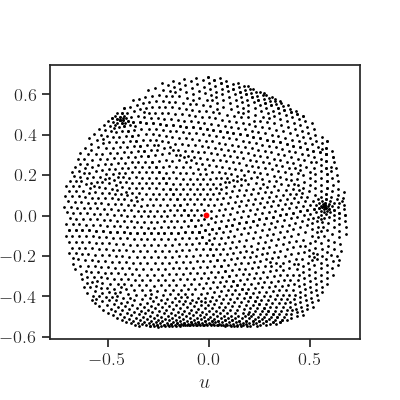

In [54]:
with set_defense_context():
    fig = plt.figure(figsize=(4, 4))
    ax = plt.axes()
    ax.scatter(u, v, c='k', s=1)
    ax.scatter(pu, pv, c='r', s=10)
    ax.set(xlabel='$u$', ylabel='$v$')
    ax.set_aspect('equal', 'box')
    plt.show()

In [55]:
bbox = [pu-a/2, pu+a/2,
        pv-a/2, pv+a/2]
idx_bbox = np.where((u >= bbox[0]) & (u <= bbox[1])
                    & (v >= bbox[2]) & (v <= bbox[3]))[0]


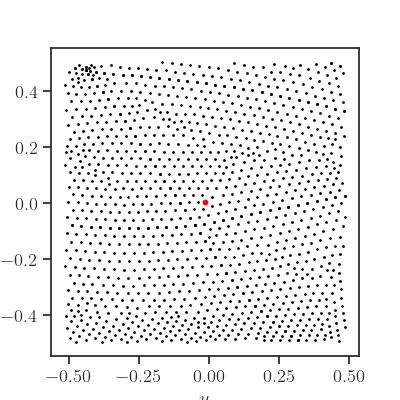

In [56]:
with set_defense_context():
    fig = plt.figure(figsize=(4, 4))
    ax = plt.axes()
    ax.scatter(*X_trans[idx_bbox, :-1].T, c='k', s=1)
    ax.scatter(pu, pv, c='r', s=10)
    ax.set(xlabel='$u$', ylabel='$v$')
    ax.set_aspect('equal', 'box')
    plt.show()